In [ ]:
import io
import csv
import math
import os
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
drive.mount('/content/drive', force_remount=True)

file_path = '/content/drive/MyDrive/Tugas Akhir/Dataset/ip102/ip102_c5_v3.zip'

zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall('/content/dataset/ip102/ip102_c5_v3')
zip_ref.close()

test_dir = '/content/dataset/ip102/ip102_c5_v3/test'
train_dir = '/content/dataset/ip102/ip102_c5_v3/train'
val_dir = '/content/dataset/ip102/ip102_c5_v3/val'

Mounted at /content/drive


In [ ]:
EPOCHS = 100
BATCH_SIZE = 32
IMG_WIDTH, IMG_HEIGHT = 224, 224
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

normal_datagen = ImageDataGenerator(
    rescale=1./255
)

train_data = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = normal_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = normal_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 875 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 125 images belonging to 5 classes.


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                           

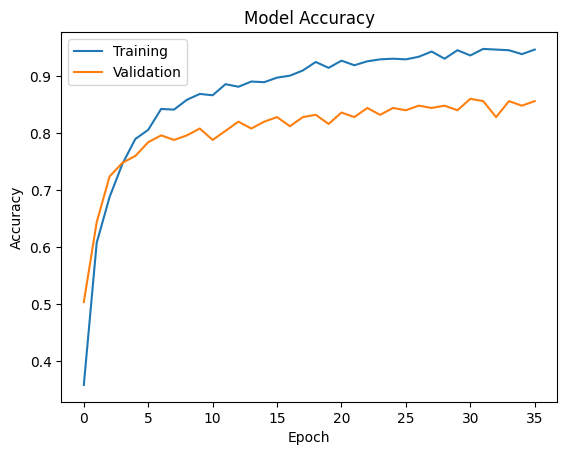

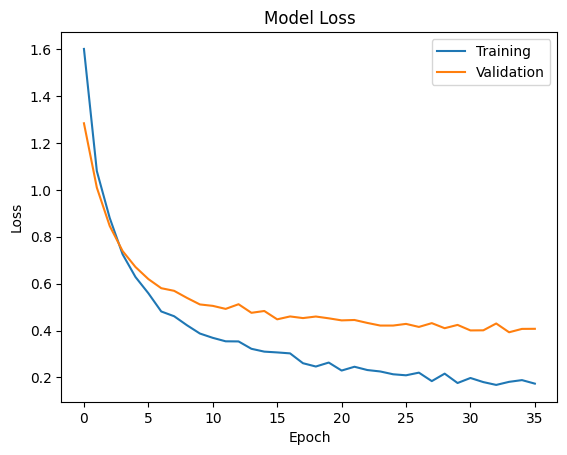

4/4 - 7s - loss: 0.2557 - accuracy: 0.9360 - 7s/epoch - 2s/step
Test accuracy: 0.9359999895095825
Test Loss: 0.25568878650665283
4/4 [==============================] - 7s 1s/step
[[22  0  0  0  3]
 [ 1 23  0  0  1]
 [ 0  0 25  0  0]
 [ 0  0  0 25  0]
 [ 1  0  0  2 22]]
                   precision    recall  f1-score   support

Brown Planthopper       0.92      0.88      0.90        25
      Grasshopper       1.00      0.92      0.96        25
     Mole Cricket       1.00      1.00      1.00        25
 Rice Leaf Hopper       0.93      1.00      0.96        25
 Rice Leaf Roller       0.85      0.88      0.86        25

         accuracy                           0.94       125
        macro avg       0.94      0.94      0.94       125
     weighted avg       0.94      0.94      0.94       125



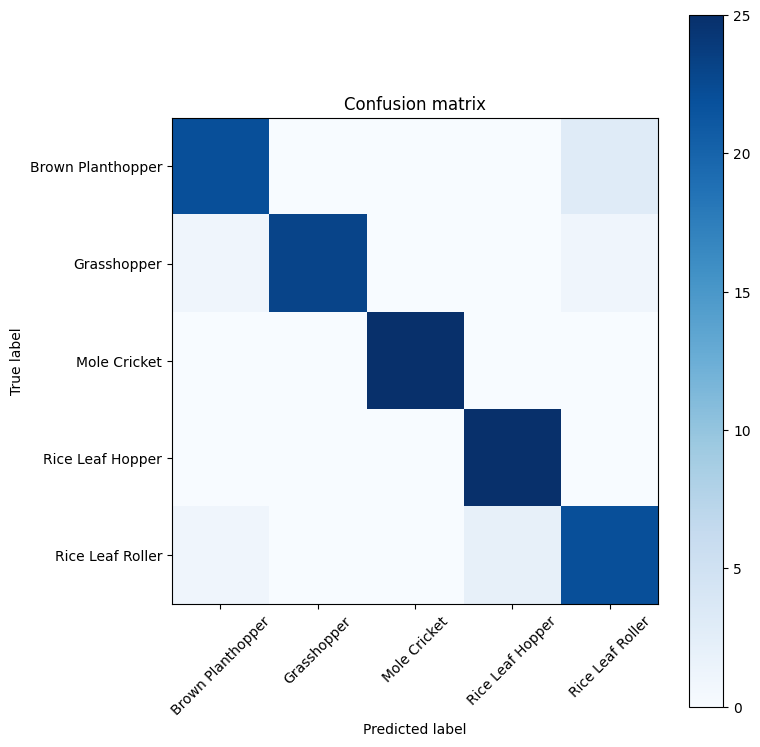

In [ ]:
LEARNING_RATE = 1e-4
OPTIMIZER = optimizers.RMSprop(learning_rate=LEARNING_RATE)

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

for layer in base_model.layers:
  layer.trainable = False

# model architecture
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(train_data.num_classes, activation='softmax')
])

model.summary()

model.compile(
    optimizer=OPTIMIZER,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# train model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

# show accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# show loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# test model
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)

print('Test accuracy:', test_accuracy)
print('Test Loss:', test_loss)

# show confussion matrix and classification report
y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=test_data.class_indices.keys())

print(cm)
print(cr)

# show heatmap
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
tick_marks = np.arange(len(val_data.class_indices))
plt.xticks(tick_marks, val_data.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, val_data.class_indices.keys())
plt.tight_layout()
plt.show()

In [ ]:
# get f1-scores
report_lines = cr.strip().split('\n')
class_labels = []
f1_scores = []

for line in report_lines[2:-4]:
    data = line.split()
    class_label = data[0]
    f1_score = float(data[-2])
    class_labels.append(class_label)
    f1_scores.append(f1_score)

f1_score_belalang, f1_score_orong_orong, f1_score_penggulung_daun, f1_score_wereng_cokelat, f1_score_wereng_hijau = f1_scores
print(f1_score_belalang, f1_score_orong_orong, f1_score_penggulung_daun, f1_score_wereng_cokelat, f1_score_wereng_hijau)

# convert model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_file = "/content/drive/MyDrive/Tugas Akhir/Model/Pemilihan Model/Tflite/mobilenetv2_rmsprop_e4.tflite"
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

model_size = os.path.getsize(tflite_model_file)
model_size_kb = model_size / 1024
model_size_mb = model_size_kb / 1024

print('Model size: {:.2f} ({:.2f} MB)'.format(model_size_kb, model_size_mb))

# add data to csv file
csv_path = "/content/drive/MyDrive/Tugas Akhir/Model/Pemilihan Model/perbandingan_model.csv"

MODEL = base_model_name = base_model.name.split('_')[0]
OPTIMIZER = OPTIMIZER.__class__.__name__
ACCURACY = round(test_accuracy, 2)
SIZE = round(model_size_mb, 2)

fieldnames = [
    "Model",
    "Optimizer",
    "Learning Rate",
    "Epochs",
    "Accuracy",
    "Size",
    "F1-Score Belalang",
    "F1-Score Orong-Orong",
    "F1-Score Penggulung Daun",
    "F1-Score Wereng Cokelat",
    "F1-Score Wereng Hijau",
]

data = [
    {
        "Model": MODEL,
        "Optimizer": OPTIMIZER,
        "Learning Rate": LEARNING_RATE,
        "Epochs": EPOCHS,
        "Accuracy": ACCURACY,
        "Size": SIZE,
        "F1-Score Belalang": f1_score_belalang,
        "F1-Score Orong-Orong": f1_score_orong_orong,
        "F1-Score Penggulung Daun": f1_score_penggulung_daun,
        "F1-Score Wereng Cokelat": f1_score_wereng_cokelat,
        "F1-Score Wereng Hijau": f1_score_wereng_hijau,
    },
]

if os.path.isfile(csv_path):
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)

        for row in data:
            writer.writerow(row)
else:
    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)

        writer.writeheader()

        for row in data:
            writer.writerow(row)

0.9 0.96 1.0 0.96 0.86


Model size: 9301.86 (9.08 MB)
